# **Electricity consumption forecasting with XGBoost and LightGBM**

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Custom utility functions
from utils.time_series_preprocessing import parse_decimal, sliding_window_from_dataframe, walk_forward_validation, create_time_features

sns.set_theme()

In [3]:
electricity_df = pd.read_csv("./data/electricity_consumption_dataset.csv")
electricity_df.head()

,Date,Time,Consumption Amount (MWh)
0,31.12.2015,00:00,"29.590,88"
1,31.12.2015,01:00,"27.785,43"
2,31.12.2015,02:00,"26.516,53"
3,31.12.2015,03:00,"26.091,62"
4,31.12.2015,04:00,"25.871,54"


## 1. Dataframe preprocessing

In [4]:
# Convert to a desired data formats - datetime and float
electricity_df["Date"] = pd.to_datetime(electricity_df["Date"], format="%d.%m.%Y")
electricity_df["Time"] = pd.to_datetime(electricity_df["Time"], format="%H:%M")
electricity_df["Consumption Amount (MWh)"] = electricity_df["Consumption Amount (MWh)"].map(parse_decimal)

# Create Datetime column and drop the unnecessary ones
electricity_df["Datetime"] = pd.to_datetime(electricity_df["Date"].dt.date.astype(str) + " " + electricity_df["Time"].dt.time.astype(str))
electricity_df = electricity_df.drop(["Date", "Time"], axis=1)

electricity_df.head()

,Consumption Amount (MWh),Datetime
0,29590.88,2015-12-31 00:00:00
1,27785.43,2015-12-31 01:00:00
2,26516.53,2015-12-31 02:00:00
3,26091.62,2015-12-31 03:00:00
4,25871.54,2015-12-31 04:00:00


## 2. Exploratory data analysis

## 2.1. Descriptive analysis

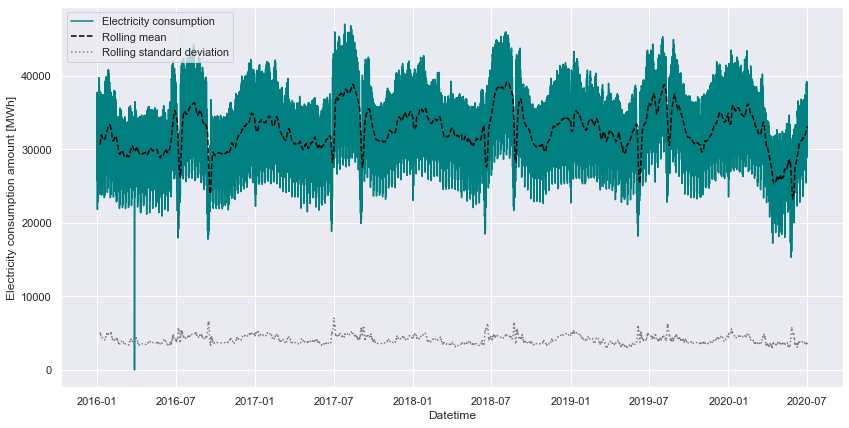

In [5]:
plt.figure(figsize=(14,7))
plt.plot(
    electricity_df["Datetime"], electricity_df["Consumption Amount (MWh)"], 
    color="teal", label="Electricity consumption"
)
plt.plot(
    electricity_df["Datetime"], 
    electricity_df["Consumption Amount (MWh)"].rolling(24*7).mean(), 
    label="Rolling mean", color="black", linestyle="--"
)
plt.plot(
    electricity_df["Datetime"], 
    electricity_df["Consumption Amount (MWh)"].rolling(24*7).std(), 
    label="Rolling standard deviation", color="gray", linestyle=":"
)
plt.xlabel("Datetime")
plt.ylabel("Electricity consumption amount [MWh]")
plt.legend(loc="best")

In [6]:
electricity_df.describe()

,Consumption Amount (MWh)
count,39456.000000
mean,32533.533338
std,5007.130035
min,0.000000
25%,28624.275000
50%,32719.710000
75%,36082.967500
max,47062.400000


## 2.2. Handling outliers

<AxesSubplot:title={'center':'Thresholding Consumption Amount < 10 000 [MWh]'}>

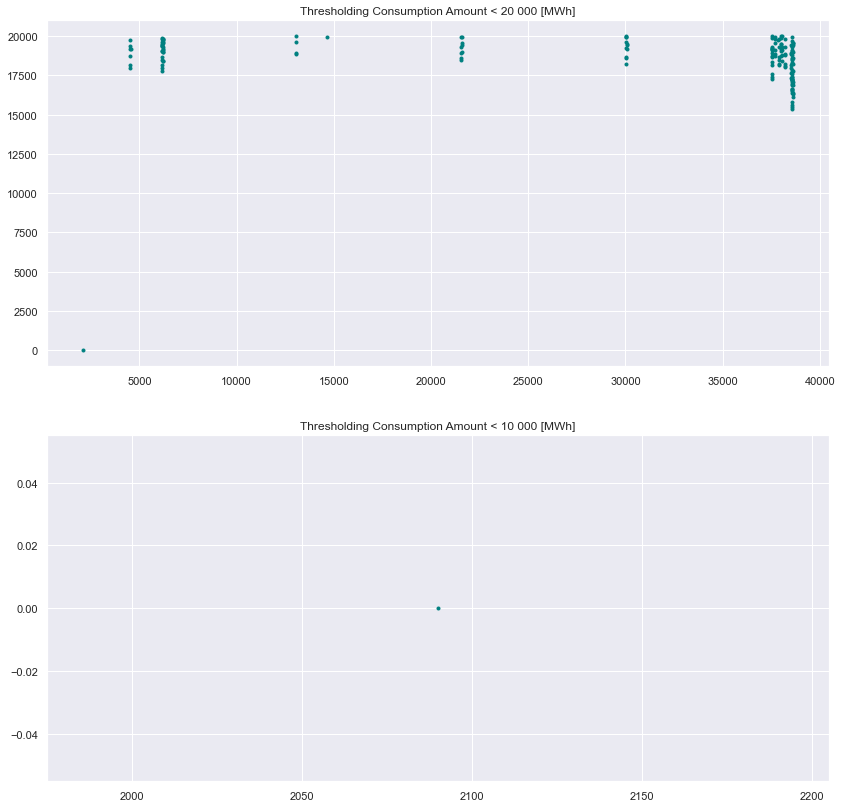

In [7]:
plt.figure(figsize=(14,14))
plt.subplot(2,1,1)
electricity_df["Consumption Amount (MWh)"][electricity_df["Consumption Amount (MWh)"] < 20000].plot(color="teal", style=".")
plt.title("Thresholding Consumption Amount < 20 000 [MWh]")
plt.subplot(2,1,2)
plt.title("Thresholding Consumption Amount < 10 000 [MWh]")
electricity_df["Consumption Amount (MWh)"][electricity_df["Consumption Amount (MWh)"] < 10000].plot(color="teal", style=".")

In [8]:
electricity_df = electricity_df[electricity_df["Consumption Amount (MWh)"] > 10000]

# 3. Forecasting with XGBoost and LightGBM

## 3.1. Sliding window approach

In [6]:
sw = sliding_window_from_dataframe(electricity_df, "Consumption Amount (MWh)")
# 1st column is a current value; 2nd column is a next value
sw

array([[     nan, 29590.88],
       [29590.88, 27785.43],
       [27785.43, 26516.53],
       ...,
       [38029.17, 37113.48],
       [37113.48, 35686.77],
       [35686.77,      nan]])

In [50]:
model = XGBRegressor(objective="reg:squarederror", n_estimators=1000)

In [8]:
error, y_test, predictions = walk_forward_validation(model=model, data=sw[1:-1, :], test_size=0.15)

Expected = 26883.3, Predicted = 25388.31640625
Expected = 25377.79, Predicted = 26495.21484375
Expected = 32424.54, Predicted = 32934.1484375
Expected = 37165.41, Predicted = 37457.08984375
Expected = 27931.4, Predicted = 28928.1171875
Expected = 31174.06, Predicted = 32618.91796875
Expected = 33032.97, Predicted = 31971.787109375
Expected = 37289.16, Predicted = 37961.22265625
Expected = 31614.12, Predicted = 28640.509765625
Expected = 27690.6, Predicted = 27419.08984375
Expected = 32519.05, Predicted = 34923.625
Expected = 28930.74, Predicted = 32275.01953125
Expected = 35613.14, Predicted = 35144.03125
Expected = 37790.43, Predicted = 37711.38671875
Expected = 31006.77, Predicted = 30761.974609375
Expected = 26360.69, Predicted = 27466.52734375
Expected = 26870.5, Predicted = 27033.107421875
Expected = 27907.3, Predicted = 27218.828125
Expected = 33006.04, Predicted = 33583.65625
Expected = 35011.71, Predicted = 35084.03515625
Expected = 35814.77, Predicted = 33575.52734375
Expected

In [9]:
print(error)

1105.2149013637227


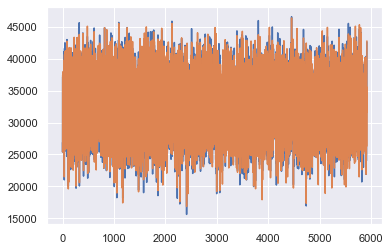

In [10]:
plt.plot(y_test)
plt.plot(predictions)

In [51]:
X = sw[1:-1, 0]
y = sw[1:-1, 1]

X_train = X[:-1000]
y_train = y[:-1000]
X_test = X[-100:]
y_test = y[-100:]

In [52]:
model.fit(X_train.reshape(-1,1), y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [53]:
y_pred = model.predict(X_test)

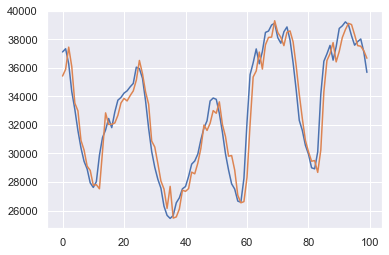

In [54]:
plt.plot(y_test)
plt.plot(y_pred)

In [68]:
forecasts = list()
x = X[-1000:]
for _ in range(40):
    pred = model.predict(x)
    x = pred
    forecasts.extend(x)

In [69]:
temp = list(X) + forecasts

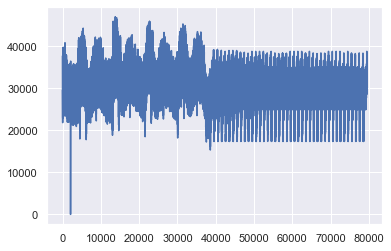

In [70]:
plt.plot(temp)

## 3.2. Lag features approach

### 3.2.1. Time series split cross-validation

In [9]:
# 8-months forecasting
tss = TimeSeriesSplit(n_splits=5, test_size=24*(365 // 3)*2, gap=24)
electricity_df = electricity_df.sort_index()

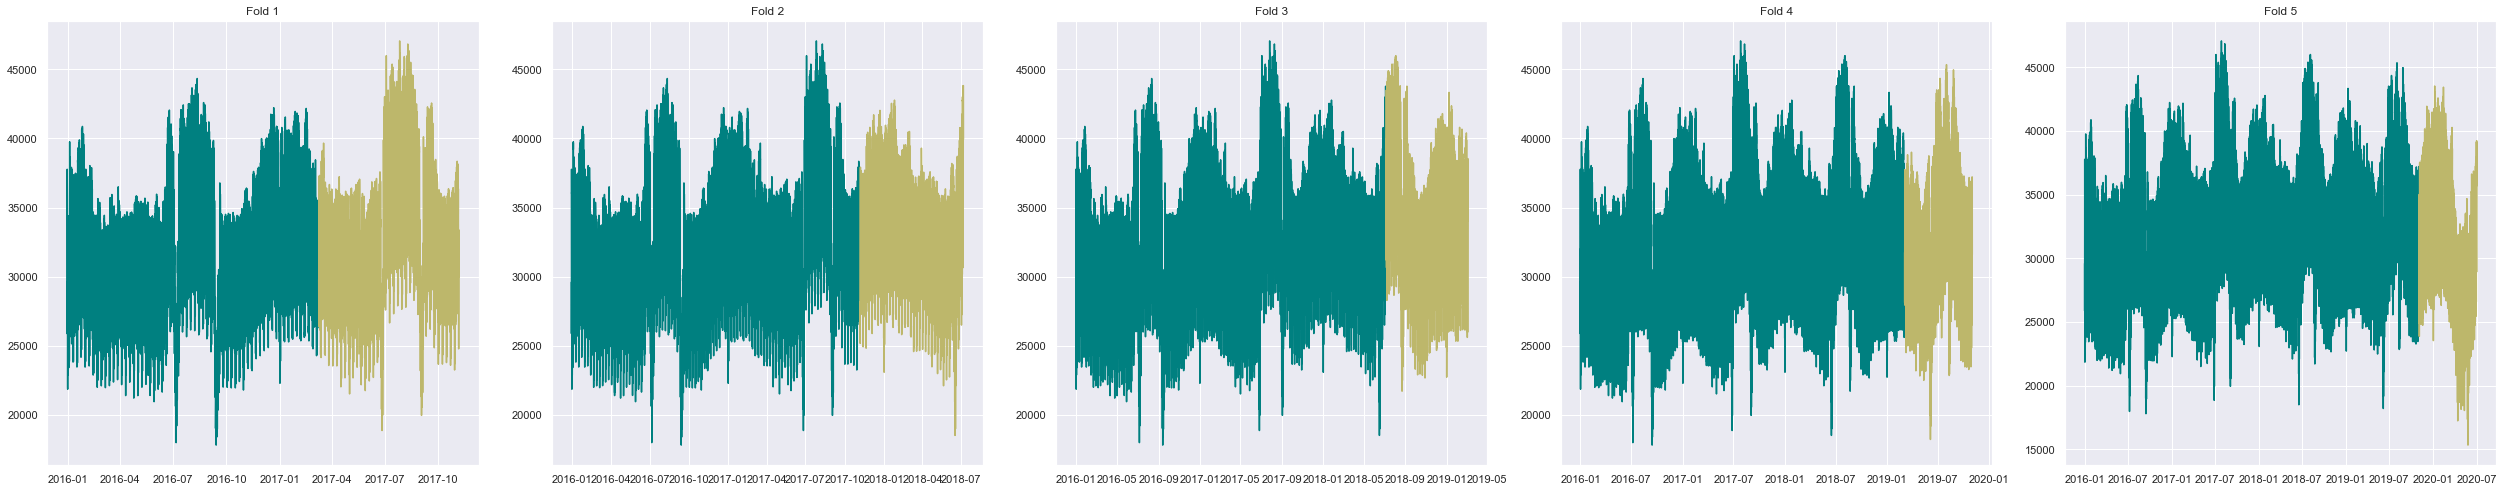

In [10]:
plt.figure(figsize=(35,7))
for i, (train_idx, val_idx) in enumerate(tss.split(electricity_df)):
    plt.subplot(1,5,i+1)
    train = electricity_df.iloc[train_idx]
    val = electricity_df.iloc[val_idx]

    plt.title(f"Fold {i+1}")
    plt.plot(train["Datetime"], train["Consumption Amount (MWh)"], color="teal", label="Train data")
    plt.plot(val["Datetime"], val["Consumption Amount (MWh)"], color="darkkhaki", label="Validation data")
plt.tight_layout()

### 3.2.2. Add time-related features

In [11]:
electricity_df = create_time_features(electricity_df, "Datetime")
electricity_df = electricity_df.set_index("Datetime")
electricity_df.head()

,Consumption Amount (MWh),hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2015-12-31 00:00:00,29590.88,0,3,4,12,2015,365,31,53
2015-12-31 01:00:00,27785.43,1,3,4,12,2015,365,31,53
2015-12-31 02:00:00,26516.53,2,3,4,12,2015,365,31,53
2015-12-31 03:00:00,26091.62,3,3,4,12,2015,365,31,53
2015-12-31 04:00:00,25871.54,4,3,4,12,2015,365,31,53


### 3.2.3. Create lag features

In [12]:
consumption_amount_map = electricity_df["Consumption Amount (MWh)"].to_dict()

electricity_df["8 months lag"] = (electricity_df.index - pd.Timedelta("242 days")).map(consumption_amount_map)
electricity_df["6 months lag"] = (electricity_df.index - pd.Timedelta("182 days")).map(consumption_amount_map)
electricity_df["4 months lag"] = (electricity_df.index - pd.Timedelta("91 days")).map(consumption_amount_map)

electricity_df.tail()

,Consumption Amount (MWh),hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,8 months lag,6 months lag,4 months lag
Datetime,,,,,,,,,,,,
2020-06-30 19:00:00,37594.26,19,1,2,6,2020,182,30,27,36056.96,34949.77,33882.07
2020-06-30 20:00:00,37844.68,20,1,2,6,2020,182,30,27,35130.19,32996.79,33834.92
2020-06-30 21:00:00,38029.17,21,1,2,6,2020,182,30,27,33947.64,31645.02,32654.01
2020-06-30 22:00:00,37113.48,22,1,2,6,2020,182,30,27,32877.69,29917.39,31834.47
2020-06-30 23:00:00,35686.77,23,1,2,6,2020,182,30,27,31590.75,29486.66,30649.75


### 3.2.4. Cross validation training - XGBoost

In [35]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*(365 // 3)*2, gap=24)
electricity_df = electricity_df.sort_index()

predictions = list()
scores = list()

for i, (train_idx, val_idx) in enumerate(tss.split(electricity_df)):
    train = electricity_df.iloc[train_idx]
    val = electricity_df.iloc[val_idx]

    X_train, y_train = train.iloc[:, 1:], train.iloc[:, 0]
    X_val, y_val = val.iloc[:, 1:], val.iloc[:, 0]

    model = XGBRegressor(
        booster="gbtree",
        n_estimators=1500,
        objective="reg:squarederror",
        max_depth=5
    )

    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=100)

    y_pred = model.predict(X_val)
    score = mean_squared_error(y_val, y_pred)

    predictions.append(y_pred)
    scores.append(score)
    

[0]	validation_0-rmse:22476.31384	validation_1-rmse:23948.08781
[100]	validation_0-rmse:398.74925	validation_1-rmse:4115.42237
[200]	validation_0-rmse:292.75975	validation_1-rmse:4125.85493
[300]	validation_0-rmse:233.94837	validation_1-rmse:4135.71770
[400]	validation_0-rmse:197.40715	validation_1-rmse:4135.79619
[500]	validation_0-rmse:171.32543	validation_1-rmse:4137.77180
[600]	validation_0-rmse:150.30239	validation_1-rmse:4142.03524
[700]	validation_0-rmse:132.65507	validation_1-rmse:4142.50003
[800]	validation_0-rmse:119.14241	validation_1-rmse:4141.78696
[900]	validation_0-rmse:107.76008	validation_1-rmse:4142.59837
[1000]	validation_0-rmse:99.16452	validation_1-rmse:4142.91559
[1100]	validation_0-rmse:90.01718	validation_1-rmse:4143.13544
[1200]	validation_0-rmse:81.68564	validation_1-rmse:4143.15163
[1300]	validation_0-rmse:75.65731	validation_1-rmse:4142.86744
[1400]	validation_0-rmse:69.45292	validation_1-rmse:4143.91710
[1499]	validation_0-rmse:65.16941	validation_1-rmse:41

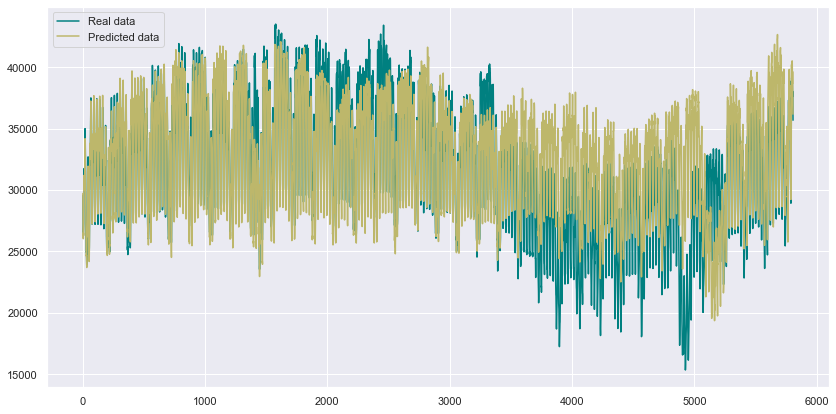

In [38]:
plt.figure(figsize=(14,7))
plt.plot(np.array(val["Consumption Amount (MWh)"]), color="teal", label="Real data")
plt.plot(predictions[-1], color="darkkhaki", label="Predicted data")
plt.legend(loc="best")

### 3.2.5. Future electricity consumption forecasting - XGBoost

In [39]:
# Retrain

X, y = electricity_df.iloc[:, 1:], electricity_df.iloc[:, 0]

model = XGBRegressor(
    booster="gbtree",
    n_estimators=1000,
    objective="reg:squarederror",
    max_depth=5
)

model.fit(X, y, eval_set=[(X, y)], verbose=100)

[0]	validation_0-rmse:23129.30333
[100]	validation_0-rmse:914.84068
[200]	validation_0-rmse:686.82347
[300]	validation_0-rmse:592.70371
[400]	validation_0-rmse:521.82940
[500]	validation_0-rmse:472.30945
[600]	validation_0-rmse:427.13718
[700]	validation_0-rmse:390.79535
[800]	validation_0-rmse:362.98509
[900]	validation_0-rmse:336.35268
[999]	validation_0-rmse:318.22620


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [40]:
str(electricity_df.index.max()).split(" ")[0]

'2020-06-30'

In [43]:
future_df = pd.DataFrame(index=pd.date_range("2020-06-30", "2020-12-30", freq="1h"))

In [52]:
df = pd.concat([electricity_df, future_df])
df["Datetime"] = df.index
df = df.reset_index()
df = df.drop(columns=["index"], axis=1)
df = create_time_features(df, "Datetime")

df = df.set_index("Datetime")

consumption_amount_map = df["Consumption Amount (MWh)"].to_dict()

df["8 months lag"] = (df.index - pd.Timedelta("242 days")).map(consumption_amount_map)
df["6 months lag"] = (df.index - pd.Timedelta("182 days")).map(consumption_amount_map)
df["4 months lag"] = (df.index - pd.Timedelta("91 days")).map(consumption_amount_map)

df.tail()

,Consumption Amount (MWh),hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,8 months lag,6 months lag,4 months lag
Datetime,,,,,,,,,,,,
2020-12-29 20:00:00,NaN,20,1,4,12,2020,364,29,53,27846.77,NaN,NaN
2020-12-29 21:00:00,NaN,21,1,4,12,2020,364,29,53,27690.60,NaN,NaN
2020-12-29 22:00:00,NaN,22,1,4,12,2020,364,29,53,26795.92,NaN,NaN
2020-12-29 23:00:00,NaN,23,1,4,12,2020,364,29,53,25871.43,NaN,NaN
2020-12-30 00:00:00,NaN,0,2,4,12,2020,365,30,53,25064.09,NaN,NaN


In [65]:
future_df = df[df["Consumption Amount (MWh)"].isna()]
future_df

,Consumption Amount (MWh),hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,8 months lag,6 months lag,4 months lag
Datetime,,,,,,,,,,,,
2020-06-30 00:00:00,NaN,0,1,2,6,2020,182,30,27,29417.56,31765.23,29211.65
2020-06-30 01:00:00,NaN,1,1,2,6,2020,182,30,27,28133.75,29871.61,27303.71
2020-06-30 02:00:00,NaN,2,1,2,6,2020,182,30,27,27358.60,28245.76,26210.44
2020-06-30 03:00:00,NaN,3,1,2,6,2020,182,30,27,26780.09,27664.76,25389.27
2020-06-30 04:00:00,NaN,4,1,2,6,2020,182,30,27,26511.54,27337.63,25070.93
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-29 20:00:00,NaN,20,1,4,12,2020,364,29,53,27846.77,NaN,NaN
2020-12-29 21:00:00,NaN,21,1,4,12,2020,364,29,53,27690.60,NaN,NaN
2020-12-29 22:00:00,NaN,22,1,4,12,2020,364,29,53,26795.92,NaN,NaN


In [66]:
future_df["Consumption Amount (MWh) - Prediction"] = model.predict(future_df.iloc[:, 1:])

c:\Users\Kamil\anaconda3\envs\blue\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [68]:
electricity_df = electricity_df.reset_index()
electricity_df = electricity_df.drop(columns=["index"], axis=1)
electricity_df.head()

,Datetime,Consumption Amount (MWh),hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,8 months lag,6 months lag,4 months lag
0,2015-12-31 00:00:00,29590.88,0,3,4,12,2015,365,31,53,NaN,NaN,NaN
1,2015-12-31 01:00:00,27785.43,1,3,4,12,2015,365,31,53,NaN,NaN,NaN
2,2015-12-31 02:00:00,26516.53,2,3,4,12,2015,365,31,53,NaN,NaN,NaN
3,2015-12-31 03:00:00,26091.62,3,3,4,12,2015,365,31,53,NaN,NaN,NaN
4,2015-12-31 04:00:00,25871.54,4,3,4,12,2015,365,31,53,NaN,NaN,NaN


In [70]:
future_df = future_df.reset_index()
future_df = future_df.drop(columns=["index"], axis=1)
future_df.head()

,Datetime,Consumption Amount (MWh),hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,8 months lag,6 months lag,4 months lag,Consumption Amount (MWh) - Prediction
0,2020-06-30 00:00:00,NaN,0,1,2,6,2020,182,30,27,29417.56,31765.23,29211.65,33943.593750
1,2020-06-30 01:00:00,NaN,1,1,2,6,2020,182,30,27,28133.75,29871.61,27303.71,32877.042969
2,2020-06-30 02:00:00,NaN,2,1,2,6,2020,182,30,27,27358.60,28245.76,26210.44,31335.658203
3,2020-06-30 03:00:00,NaN,3,1,2,6,2020,182,30,27,26780.09,27664.76,25389.27,30654.875000
4,2020-06-30 04:00:00,NaN,4,1,2,6,2020,182,30,27,26511.54,27337.63,25070.93,30152.759766


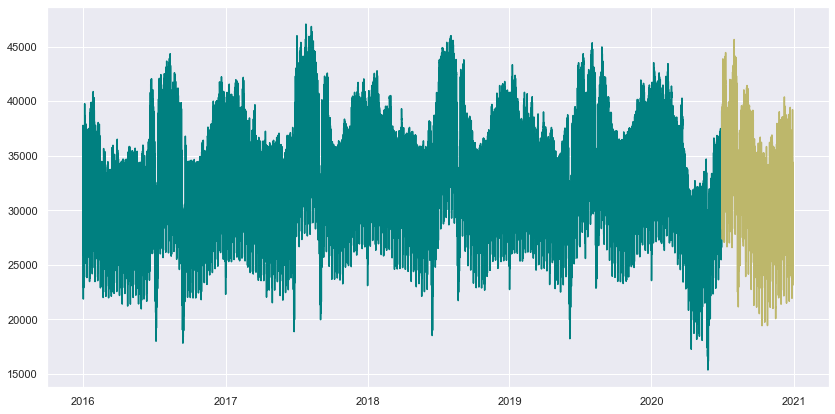

In [71]:
plt.figure(figsize=(14,7))
plt.plot(electricity_df["Datetime"], electricity_df["Consumption Amount (MWh)"], color="teal")
plt.plot(future_df["Datetime"], future_df["Consumption Amount (MWh) - Prediction"], color="darkkhaki")

In [143]:
model.save_model("xgb.json")

### 3.2.6. Cross validation training - LightGBM

In [32]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*(365 // 3)*2, gap=24)
electricity_df = electricity_df.sort_index()

predictions = list()
scores = list()

for i, (train_idx, val_idx) in enumerate(tss.split(electricity_df)):
    train = electricity_df.iloc[train_idx]
    val = electricity_df.iloc[val_idx]

    X_train, y_train = train.iloc[:, 1:], train.iloc[:, 0]
    X_val, y_val = val.iloc[:, 1:], val.iloc[:, 0]

    model = LGBMRegressor(
        boosting_type="gbdt",
        n_estimators=1000,
        objective="mse",
        max_depth=5
    )

    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

    y_pred = model.predict(X_val)
    score = mean_squared_error(y_val, y_pred)

    predictions.append(y_pred)
    scores.append(score)

[1]	training's l2: 2.03049e+07	valid_1's l2: 2.52143e+07
[2]	training's l2: 1.74467e+07	valid_1's l2: 2.28315e+07
[3]	training's l2: 1.51835e+07	valid_1's l2: 2.07002e+07
[4]	training's l2: 1.33708e+07	valid_1's l2: 1.88222e+07
[5]	training's l2: 1.17739e+07	valid_1's l2: 1.73146e+07
[6]	training's l2: 1.04474e+07	valid_1's l2: 1.61425e+07
[7]	training's l2: 9.33136e+06	valid_1's l2: 1.51528e+07
[8]	training's l2: 8.44624e+06	valid_1's l2: 1.44185e+07
[9]	training's l2: 7.71364e+06	valid_1's l2: 1.39119e+07
[10]	training's l2: 6.85898e+06	valid_1's l2: 1.33708e+07
[11]	training's l2: 6.31347e+06	valid_1's l2: 1.2954e+07
[12]	training's l2: 5.81715e+06	valid_1's l2: 1.26543e+07
[13]	training's l2: 5.17096e+06	valid_1's l2: 1.23999e+07
[14]	training's l2: 4.83389e+06	valid_1's l2: 1.20992e+07
[15]	training's l2: 4.54641e+06	valid_1's l2: 1.19381e+07
[16]	training's l2: 4.06237e+06	valid_1's l2: 1.19233e+07
[17]	training's l2: 3.83304e+06	valid_1's l2: 1.17445e+07
[18]	training's l2: 3.53

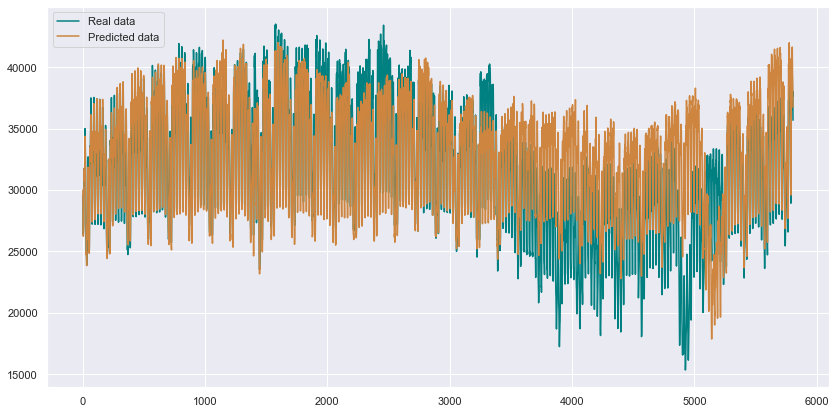

In [33]:
plt.figure(figsize=(14,7))
plt.plot(np.array(val["Consumption Amount (MWh)"]), color="teal", label="Real data")
plt.plot(predictions[-1], color="peru", label="Predicted data")
plt.legend(loc="best")

### 3.2.7. Future electricity consumption forecasting - LightGBM

In [35]:
# Retrain

X, y = electricity_df.iloc[:, 1:], electricity_df.iloc[:, 0]

model = LGBMRegressor(
    boosting_type="gbdt",
    n_estimators=1000,
    objective="mse",
    max_depth=5
)

model.fit(X, y, eval_set=[(X, y)])

[1]	training's l2: 2.16732e+07
[2]	training's l2: 1.89229e+07
[3]	training's l2: 1.66369e+07
[4]	training's l2: 1.47218e+07
[5]	training's l2: 1.31297e+07
[6]	training's l2: 1.18487e+07
[7]	training's l2: 1.07202e+07
[8]	training's l2: 9.80135e+06
[9]	training's l2: 9.04208e+06
[10]	training's l2: 8.39209e+06
[11]	training's l2: 7.844e+06
[12]	training's l2: 7.40404e+06
[13]	training's l2: 6.97779e+06
[14]	training's l2: 6.61964e+06
[15]	training's l2: 6.31794e+06
[16]	training's l2: 6.08016e+06
[17]	training's l2: 5.81681e+06
[18]	training's l2: 5.62783e+06
[19]	training's l2: 5.43249e+06
[20]	training's l2: 5.26953e+06
[21]	training's l2: 5.13567e+06
[22]	training's l2: 5.01098e+06
[23]	training's l2: 4.8925e+06
[24]	training's l2: 4.7331e+06
[25]	training's l2: 4.63693e+06
[26]	training's l2: 4.56732e+06
[27]	training's l2: 4.48019e+06
[28]	training's l2: 4.36486e+06
[29]	training's l2: 4.24099e+06
[30]	training's l2: 4.14153e+06
[31]	training's l2: 4.08026e+06
[32]	training's l2: 4

LGBMRegressor(max_depth=5, n_estimators=1000, objective='mse')

In [36]:
str(electricity_df.index.max()).split(" ")[0]

'2020-06-30'

In [37]:
future_df = pd.DataFrame(index=pd.date_range("2020-06-30", "2020-12-30", freq="1h"))

In [38]:
df = pd.concat([electricity_df, future_df])
df["Datetime"] = df.index
df = df.reset_index()
df = df.drop(columns=["index"], axis=1)
df = create_time_features(df, "Datetime")

df = df.set_index("Datetime")

consumption_amount_map = df["Consumption Amount (MWh)"].to_dict()

df["8 months lag"] = (df.index - pd.Timedelta("242 days")).map(consumption_amount_map)
df["6 months lag"] = (df.index - pd.Timedelta("182 days")).map(consumption_amount_map)
df["4 months lag"] = (df.index - pd.Timedelta("91 days")).map(consumption_amount_map)

df.tail()

,Consumption Amount (MWh),hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,8 months lag,6 months lag,4 months lag
Datetime,,,,,,,,,,,,
2020-12-29 20:00:00,NaN,20,1,4,12,2020,364,29,53,27846.77,NaN,NaN
2020-12-29 21:00:00,NaN,21,1,4,12,2020,364,29,53,27690.60,NaN,NaN
2020-12-29 22:00:00,NaN,22,1,4,12,2020,364,29,53,26795.92,NaN,NaN
2020-12-29 23:00:00,NaN,23,1,4,12,2020,364,29,53,25871.43,NaN,NaN
2020-12-30 00:00:00,NaN,0,2,4,12,2020,365,30,53,25064.09,NaN,NaN


In [39]:
future_df = df[df["Consumption Amount (MWh)"].isna()]
future_df

,Consumption Amount (MWh),hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,8 months lag,6 months lag,4 months lag
Datetime,,,,,,,,,,,,
2020-06-30 00:00:00,NaN,0,1,2,6,2020,182,30,27,29417.56,31765.23,29211.65
2020-06-30 01:00:00,NaN,1,1,2,6,2020,182,30,27,28133.75,29871.61,27303.71
2020-06-30 02:00:00,NaN,2,1,2,6,2020,182,30,27,27358.60,28245.76,26210.44
2020-06-30 03:00:00,NaN,3,1,2,6,2020,182,30,27,26780.09,27664.76,25389.27
2020-06-30 04:00:00,NaN,4,1,2,6,2020,182,30,27,26511.54,27337.63,25070.93
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-29 20:00:00,NaN,20,1,4,12,2020,364,29,53,27846.77,NaN,NaN
2020-12-29 21:00:00,NaN,21,1,4,12,2020,364,29,53,27690.60,NaN,NaN
2020-12-29 22:00:00,NaN,22,1,4,12,2020,364,29,53,26795.92,NaN,NaN


In [40]:
future_df["Consumption Amount (MWh) - Prediction"] = model.predict(future_df.iloc[:, 1:])

c:\Users\Kamil\anaconda3\envs\blue\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [42]:
electricity_df = electricity_df.reset_index()
electricity_df = electricity_df.drop(columns=["index"], axis=1)
electricity_df.head()

,Datetime,Consumption Amount (MWh),hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,8 months lag,6 months lag,4 months lag
0,2015-12-31 00:00:00,29590.88,0,3,4,12,2015,365,31,53,NaN,NaN,NaN
1,2015-12-31 01:00:00,27785.43,1,3,4,12,2015,365,31,53,NaN,NaN,NaN
2,2015-12-31 02:00:00,26516.53,2,3,4,12,2015,365,31,53,NaN,NaN,NaN
3,2015-12-31 03:00:00,26091.62,3,3,4,12,2015,365,31,53,NaN,NaN,NaN
4,2015-12-31 04:00:00,25871.54,4,3,4,12,2015,365,31,53,NaN,NaN,NaN


In [45]:
future_df = future_df.reset_index()
future_df = future_df.drop(columns=["index"], axis=1)
future_df.head()

,Datetime,Consumption Amount (MWh),hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,8 months lag,6 months lag,4 months lag,Consumption Amount (MWh) - Prediction
0,2020-06-30 00:00:00,NaN,0,1,2,6,2020,182,30,27,29417.56,31765.23,29211.65,34207.816187
1,2020-06-30 01:00:00,NaN,1,1,2,6,2020,182,30,27,28133.75,29871.61,27303.71,32815.198248
2,2020-06-30 02:00:00,NaN,2,1,2,6,2020,182,30,27,27358.60,28245.76,26210.44,31396.383714
3,2020-06-30 03:00:00,NaN,3,1,2,6,2020,182,30,27,26780.09,27664.76,25389.27,31016.601838
4,2020-06-30 04:00:00,NaN,4,1,2,6,2020,182,30,27,26511.54,27337.63,25070.93,29794.138277


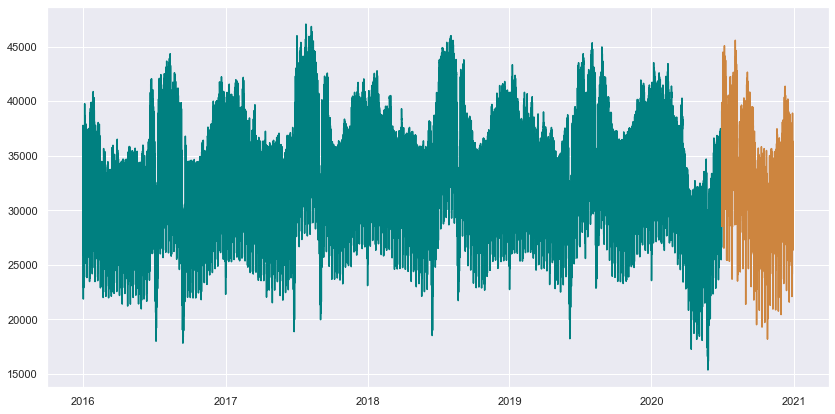

In [46]:
plt.figure(figsize=(14,7))
plt.plot(electricity_df["Datetime"], electricity_df["Consumption Amount (MWh)"], color="teal")
plt.plot(future_df["Datetime"], future_df["Consumption Amount (MWh) - Prediction"], color="peru")

In [49]:
model.booster_.save_model("lgbm.json")